# Volume-mean temperature

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.stats import linregress

In [49]:
from dask.distributed import Client, LocalCluster, wait

In [50]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=32e9,
                       silence_logs=50)
client = Client(address=cluster)

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37895 instead
  http_address["port"], self.http_server.port


In [51]:
client

Client Scheduler: tcp://127.0.0.1:44549 Dashboard: http://127.0.0.1:37895/status,Cluster Workers: 4 Cores: 8 Memory: 128.00 GB


## Read NEMO grid

In [52]:
ds_mesh = xr.open_dataset('/data/user/jkjellsson/orca05_mesh_mask.nc')
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_3D = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})

## Read NEMO

In [53]:
exp_list = ['focioifs-merge14']

In [54]:
# NEMO grid T
ds_t_all = []
for exp in exp_list:
    t = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/nemo/1y/*1y*grid_T.nc' % (exp,)
    ds_t = xr.open_mfdataset(t,combine='by_coords').rename({'time_counter':'time'})
    ds_t_all.append(ds_t)

## Global-mean profiles

In [55]:
toce_list = []
soce_list = []

toce_anom_list = []
soce_anom_list = []

for i in range(0,len(exp_list)):
    ds_t = ds_t_all[i]
    exp = exp_list[i]
    
    # Globally averaged 
    tot_vol = (da_orca05_volume * da_orca05_mask_3D).sum(('x','y')) 
    toce = (ds_t['votemper'] * da_orca05_volume * da_orca05_mask_3D).sum(('x','y')) / tot_vol
    print(toce)
    
    # Globally averaged salinity
    soce = (ds_t['vosaline'] * da_orca05_volume * da_orca05_mask_3D).sum(('x','y')) / tot_vol
    print(soce)
    
    # Remove first year
    toce_anom = toce - toce[0,:]
    soce_anom = soce - soce[0,:]
    
    toce_list.append(toce.compute())
    soce_list.append(soce.compute())
    toce_anom_list.append(toce_anom.compute())
    soce_anom_list.append(soce_anom.compute())
    

<xarray.DataArray (time: 239, deptht: 46)>
dask.array<truediv, shape=(239, 46), dtype=float64, chunksize=(10, 46), chunktype=numpy.ndarray>
Coordinates:
  * deptht   (deptht) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time     (time) datetime64[ns] 1850-07-01T06:00:00 ... 2089-07-01T06:00:00
<xarray.DataArray (time: 239, deptht: 46)>
dask.array<truediv, shape=(239, 46), dtype=float64, chunksize=(10, 46), chunktype=numpy.ndarray>
Coordinates:
  * deptht   (deptht) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time     (time) datetime64[ns] 1850-07-01T06:00:00 ... 2089-07-01T06:00:00


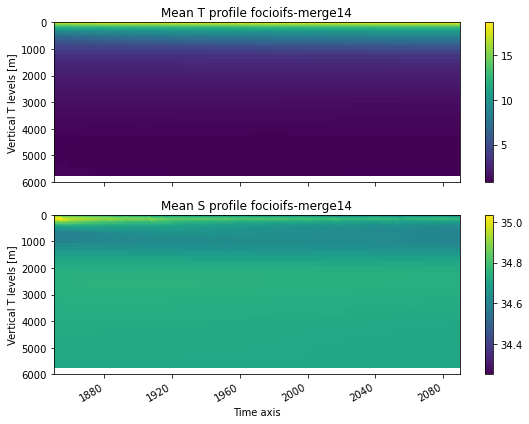

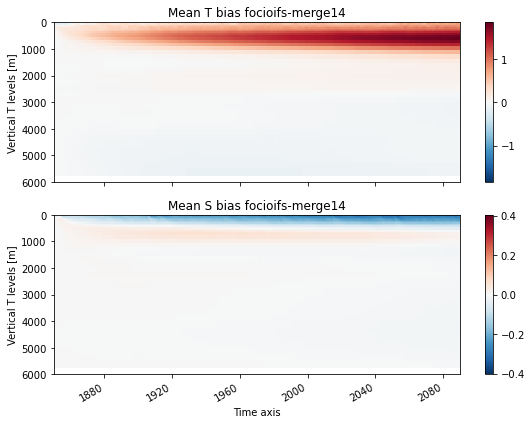

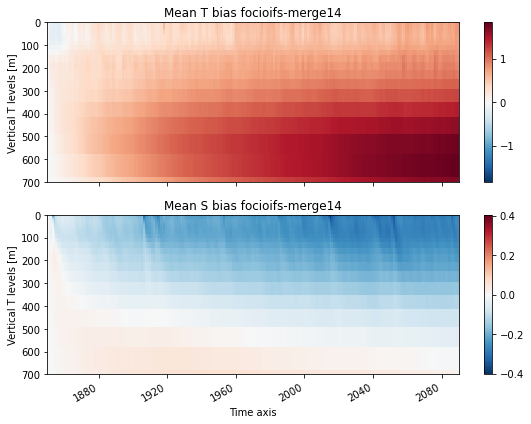

In [66]:
for i in range(0,len(exp_list)):
    
    fig1, ax1 = plt.subplots(2,1,figsize=(8,6))
    fig2, ax2 = plt.subplots(2,1,figsize=(8,6))
    fig3, ax3 = plt.subplots(2,1,figsize=(8,6))
    
    toce = toce_list[i]
    soce = soce_list[i]
    toce_anom = toce_anom_list[i]
    soce_anom = soce_anom_list[i]
    
    exp = exp_list[i]
    
    # Annual mean
    toce.plot(x='time',y='deptht',ax=ax1[0],label=exp)
    soce.plot(x='time',y='deptht',ax=ax1[1],label=exp)
    
    toce_anom.plot(x='time',y='deptht',ax=ax2[0],label=exp)
    soce_anom.plot(x='time',y='deptht',ax=ax2[1],label=exp)
    
    toce_anom.plot(x='time',y='deptht',ax=ax3[0],label=exp)
    soce_anom.plot(x='time',y='deptht',ax=ax3[1],label=exp)
    
    ax1[0].set_title('Mean T profile %s' % (exp,))
    ax1[1].set_title('Mean S profile %s' % (exp,))
    
    ax2[0].set_title('Mean T bias %s' % (exp,))
    ax2[1].set_title('Mean S bias %s' % (exp,))
    
    ax3[0].set_title('Mean T bias %s' % (exp,))
    ax3[1].set_title('Mean S bias %s' % (exp,))
    
    for ax in ax3:
        ax.set_ylim([0,700])
    
    for axs in [ax1,ax2,ax3]:
        axs[0].tick_params(labelbottom=False)
        axs[0].set_xlabel('')
        for ax in axs:
            ax.invert_yaxis()

    for fig in [fig1,fig2,fig3]:
        fig.tight_layout()
        
    fig1.savefig('global_mean_ocean_profiles.png',format='png')
    fig2.savefig('global_mean_ocean_bias.png',format='png')
    fig3.savefig('global_mean_ocean_bias_upper.png',format='png')

## Volume-averaged temperature

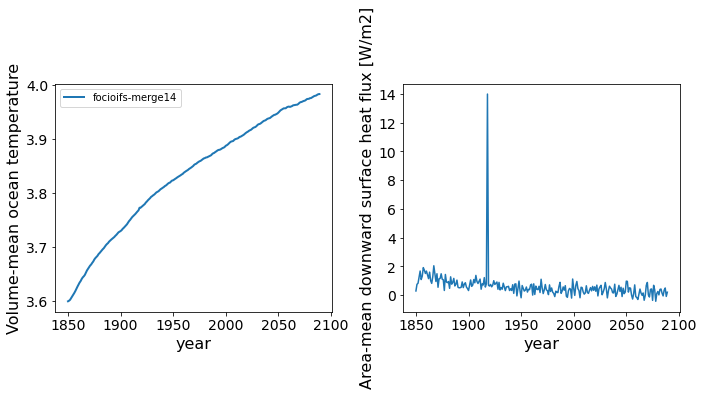

In [75]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

for i in range(0,len(exp_list)):
    toce_1d = toce_list[i]
    soce_1d = soce_list[i]
    
    exp = exp_list[i]
    
    # Ocean temperature
    tot_vol = (da_orca05_volume * da_orca05_mask_3D).sum(('x','y')) 
    toce = (toce_1d * tot_vol).sum(('deptht')) / tot_vol.sum('deptht')
    
    # Surface heat flux
    tot_area = (da_orca05_area * da_orca05_mask).sum(('x','y')) 
    hflux = (ds_t['sohefldo'] * da_orca05_mask * da_orca05_area).sum(('x','y')) / tot_area
    
    # Annual mean
    toce_mean = toce.groupby('time.year').mean('time')
    toce_mean.plot(ax=ax[0],alpha=1,label=exp,lw=2)
    
    hflux_mean = hflux.groupby('time.year').mean('time')
    hflux_mean.plot(ax=ax[1],alpha=1,label=exp)
    
    for a in ax:
        a.tick_params(labelsize=14)
        t = a.get_xlabel()
        a.set_xlabel(t,fontsize=16)
        t = a.get_ylabel()
        a.set_ylabel(t,fontsize=16)
    
ax[0].legend()
ax[0].set_ylabel('Volume-mean ocean temperature')
ax[1].set_ylabel('Area-mean downward surface heat flux [W/m2]')
fig.tight_layout()
fig.savefig('volmean_ocean_temp.pdf',format='pdf')